<a href="https://colab.research.google.com/github/drscook/BayesFlow/blob/master/BayesFlow_Cook_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://github.com/DKH707/B-ODE-DM
- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009472
- https://arxiv.org/abs/2302.09125
- https://github.com/stefanradev93/BayesFlow
- https://github.com/bayesflow-org/JANA-Paper
- https://github.com/stefanradev93/AIAgainstCorona/tree/main

In [ ]:
! pip install git+https://github.com/stefanradev93/BayesFlow
! pip install -U ipython-autotime numpy pandas tensorflow wbgapi
get_ipython().kernel.do_shutdown(True)

In [ ]:
%reload_ext autotime
import pathlib, shutil, google.colab, dataclasses, pickle, warnings, wbgapi, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from functools import partial
from scipy.integrate import odeint
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequentialNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "text.latex.preamble": r"\usepackage{{amsmath}}"})
warnings.filterwarnings(action="ignore", message=".*Could not infer format, so each element will be parsed individually.*")
mnt = '/content/drive'
google.colab.drive.mount(mnt)
RNG = np.random.default_rng(42)
EPS = 1e-8


def prior_fun():
    return {
        'alpha'  :RNG.uniform(low=0.005, high=0.99),
        'beta'   :RNG.lognormal(mean=np.log(0.25), sigma=0.3),
        'gamma'  :RNG.lognormal(mean=np.log(1/6.5), sigma=0.5),
        'delta'  :RNG.uniform(low=0.01, high=0.3),
        'epsilon':RNG.uniform(low=1/14, high=1/3),
        'eta'    :RNG.lognormal(mean=np.log(1/3.2), sigma=0.5),
        'lambda' :RNG.lognormal(mean=np.log(1.2), sigma=0.5),
        'mu'     :RNG.lognormal(mean=np.log(1/8), sigma=0.2),
        'theta'  :RNG.uniform(low=1/14, high=1/3),
        'E_0'    :RNG.gamma(shape=2, scale=30),
        'lag_I'  :RNG.lognormal(mean=np.log(8), sigma=0.2),
        'lag_R'  :RNG.lognormal(mean=np.log(8), sigma=0.2),
        'lag_D'  :RNG.lognormal(mean=np.log(8), sigma=0.2),
        # 'lag_I'  :EPS*2,
        # 'lag_R'  :EPS*2,
        # 'lag_D'  :EPS*2,
        'sigma_I':RNG.gamma(shape=1, scale=5),
        'sigma_R':RNG.gamma(shape=1, scale=5),
        'sigma_D':RNG.gamma(shape=1, scale=5),
        'psi_I'  :RNG.uniform(low=0.005, high=0.99),
        'psi_R'  :RNG.uniform(low=0.005, high=0.99),
        'psi_D'  :RNG.uniform(low=0.005, high=0.99),
    }

def ode_flow(y, t, ode_params):
    """Compute flows between classes"""
    S, E, C, I, R, D = y
    alpha, beta, gamma, delta, epsilon, eta, lam, mu, theta = ode_params
    return {
        'SE': lam * (C + beta * I) * S / sum(y),
        'EC': gamma * E,
        'CI': (1 - alpha) * eta * C,
        'CR': alpha * theta * C,
        'IR': (1 - delta) * mu * I,
        'ID': delta * epsilon * I,
    }

def ode(y, t, ode_params):
    d = ode_flow(y, t, ode_params)
    return {
        'dS': -d['SE'],
        'dE':  d['SE'] - d['EC'],
        'dC':            d['EC'] - d['CI'] - d['CR'],
        'dI':                      d['CI']           - d['IR'] - d['ID'],
        'dR':                                d['CR'] + d['IR'],
        'dD':                                                    d['ID'],
    }
# alpha or delta > 1 in posterior
def configurator_fun(forward_dict, config_dict):
    """EITHER Pre-processes output of generative model before amortizer OR post-processes output of amortizer"""
    pad = lambda X, n=3: np.expand_dims(X, axis=tuple(range(n-np.array(X).ndim)))  # adds newaxis to front until X has n dims

    if 'parameters_out' not in forward_dict:
        # pre-process before amortizer
        if 'prior_draws' not in forward_dict:
            forward_dict['prior_draws'] = np.nan
        k = config_dict['sim_mean'].shape[-1]
        sim = pad(forward_dict['sim_data'], 3)[...,-k:]
        prior = pad(forward_dict['prior_draws'], 2)
        # rescale data & prior
        forward_dict['summary_conditions'] = (sim - config_dict['sim_mean']) / config_dict['sim_std']
        forward_dict['parameters'] = (prior - config_dict['prior_mean']) / config_dict['prior_std']
        # check for problems
        forward_dict['checks'] = {
            'neg_sim_data'      :np.any(forward_dict['sim_data']    < -EPS),
            'neg_prior_draws'   :np.any(forward_dict['prior_draws'] <  EPS),
            'excess_sim_data'   :np.any(forward_dict['sim_data']    > config_dict['tot_pop']),
            'excess_prior_draws':np.any(np.isinf(forward_dict['prior_draws'])),}
        if any(forward_dict['checks'].values()):
            with open(config_dict['error_file'], "wb") as f:
                pickle.dump(forward_dict, f)
            raise Exception(f'Invalid value encountered: {forward_dict["checks"]}')
    else:
        # post-process after amortizer
        forward_dict['posterior_draws'] = pad(forward_dict['parameters_out'], 3) * config_dict['prior_std'] + config_dict['prior_mean']
    return forward_dict


@dataclasses.dataclass
class COVID():
    country: str = 'Germany'
    n_steps: int = 82
    n_coupling_layers: int = 3
    ode_params: tuple = ('alpha','beta','gamma','delta','epsilon','eta','lambda','mu','theta')
    ode_classes: tuple = ('S','E','C','I','R','D')
    obs_classes: tuple = ('dI_obs','dR_obs','dR_obs')
    name: str = 'covid_000'
    refresh: bool = False

    def __post_init__(self):
        """Initialization function that runs when instance is created"""
        # create paths
        self.root_path = pathlib.Path(mnt + f'/MyDrive/bayesian disease modeling/{self.name}')
        if self.refresh:
            # delete root_path and everything in it
            shutil.rmtree(self.root_path, ignore_errors=True)
        self.model_path = self.root_path / f'model/'
        self.model_path.mkdir(exist_ok=True, parents=True)
        self.file = {key: self.model_path / f'{key}.pkl' for key in ['calibration','diagnostic','predictive','error']}

        # get population from the World Bank
        self.iso = wbgapi.economy.coder(self.country)
        assert self.iso, f'Unrecognized country {self.country}'
        self.tot_pop = next(wbgapi.data.fetch('SP.POP.TOTL', economy=self.iso, time=2020))['value']
        self.path = self.root_path / self.iso
        self.path.mkdir(exist_ok=True)

        # initial run to detect constant priors to remove from training
        prior_draws = [prior_fun() for k in range(10)]
        self.const_params = pd.DataFrame(prior_draws).agg(['mean','std']).T.query('std < 1e-5')['mean'].to_dict()
        self.param_names = [key for key in prior_draws[0] if key not in self.const_params]
        self.param_latex = [f'${key}$' if key in ['E_0','lag_I','lag_R','lag_D'] else f'$\{key}$' for key in self.param_names]
        self.lower_bound = np.array([EPS for key in self.param_names])
        self.upper_bound = np.array([1-EPS if key in ['alpha','delta','psi_I','psi_R','psi_D'] else np.inf for key in self.param_names])
        self.classes = self.sir(prior_draws[0]).columns.tolist()

        generative_model = GenerativeModel(simulator = Simulator(simulator_fun=self.sir),
                                           prior = Prior(prior_fun=lambda: np.array([val for key, val in prior_fun().items() if key in self.param_names]),
                                                         param_names=self.param_names))

        # Read or create calibration sims
        self.calibration = self.read_or_create(file=self.file['calibration'], fun=lambda: generative_model(1000))
        p, s = self.calibration['prior_draws'], self.calibration['sim_data'][...,-len(self.obs_classes):]
        config_dict = {
            'prior_min' : p.min(axis=0),
            'prior_max' : p.max(axis=0),
            'prior_mean': p.mean(axis=0),
            'prior_std' : np.fmax(p.std(axis=0), EPS),
            'sim_min'   : s.min(axis=0),
            'sim_max'   : s.max(axis=0),
            'sim_mean'  : s.mean(axis=0),
            'sim_std'   : np.fmax(s.std(axis=0), EPS),
            'tot_pop'   : self.tot_pop,
            'error_file': self.file['error'],
        }

        # I don't know that these mean - I lifted them from the JANA paper code
        coupling_settings = {
            "dense_args": dict(units=128, activation="swish", kernel_regularizer=None),
            "num_dense": 2,
            "dropout": False,
        }

        self.model = Trainer(
            checkpoint_path = self.model_path, max_to_keep = 3, #memory = True, memory is broken for now
            generative_model = generative_model,
            configurator = partial(configurator_fun, config_dict=config_dict),
            amortizer = AmortizedPosterior(summary_net = SequentialNetwork(),
                                           inference_net = InvertibleNetwork(num_params=len(self.param_names),
                                                                             num_coupling_layers=self.n_coupling_layers,
                                                                             coupling_settings=coupling_settings)),
            )

    def read_or_create(self, file, fun=None, refresh=False):
        """Read or create pickle for simulation results"""
        try:
            assert not refresh
            with open(file, "rb") as f:
                sims = pickle.load(f)
            print(f'{file} successfully read')
        except Exception as e:
            print(f'Running sims due to error: {e}')
            with open(file, "wb") as f:
                sims = fun()
                pickle.dump(sims, f)
        return sims

    def sir(self, prior_values):
        """Run ODE and OBS models"""
        # combine constant and random parameters
        try:
            params = self.const_params | prior_values  # if prior_values was passed as dict
        except:
            params = self.const_params | dict(zip(self.param_names, prior_values))  # if prior_values was passed as list
        assert all(v > EPS for v in params.values()), f'Negative parameter encountered: {params}'
        ode_params = [params[key] for key in self.ode_params]

        # set initial conditions
        y0 = [self.tot_pop-params['E_0'], params['E_0'], 0, 0, 0, 0]
        # solve ODE
        ode_fun = lambda y, t: list(ode(y, t, ode_params).values())
        Y = pd.DataFrame(odeint(ode_fun, y0, np.arange(self.n_steps)), columns=self.ode_classes).clip(0, self.tot_pop).rename_axis('t')

        # make observations
        # get flows
        obs_fun = lambda y: ode_flow(y, None, ode_params)
        flow = Y.apply(obs_fun, axis=1).apply(pd.Series)
        dY = {'I': flow['CI'], 'R': flow['IR'], 'D': flow['ID']}
        # apply lags and noise for each obs_class
        for c, dy in dY.items():
            # get lag, psi, sig for this class
            lag, psi, sig = params['lag_'+c], params['psi_'+c], params['sigma_'+c]
            # shift flow by lag and multiply by psi to reflect the proportion of new cases that get detected
            o = (dy.shift(int(lag)).fillna(0) * psi).clip(0, self.tot_pop)
            # inject reporting noise
            e = np.sqrt(o) * sig * RNG.standard_normal(o.shape)
            # add observed cases to observations
            Y[f'd{c}_obs'] = o + e
            # Y[f'{c}_obs'] = (o + e).cumsum()
        return Y.clip(0, self.tot_pop)


    def get_real_data(self, n_rows=None, alignment=None):
        """Download and prepare data from Johns Hopkins"""
        def fetch(cl):
            return (
                pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{cl}_global.csv', sep=",")
                .drop(columns=['Province/State','Lat','Long'])
                .groupby('Country/Region').sum()
                .loc[self.country]
            )
        R = (
            pd.DataFrame(
            {'dI_real':fetch('confirmed'), 'dR_real':fetch('recovered'), 'dD_real':fetch('deaths')})
            .assign(date = lambda x: pd.to_datetime(x.index)).set_index('date')
            .diff().dropna()
            .clip(0,self.tot_pop).astype(int)
            .iloc[:n_rows]
            )
        shift = lambda s: R.iloc[s:s+self.n_steps]#.values
        if alignment is None:
            obs_cols = [c.replace('real','obs') for c in R.columns]
            L = []
            for s in range(R.shape[0]-self.n_steps):
                date = R.index[s]
                samples = self.sample(n_samples=10, data=shift(s), ensemble=True)
                # I previously used a performance metric to minimize negative parameters, but that did not work as hope.
                # I'm now trying cosine similarity between shifted data and the prediction it yields
                A = shift(s).values.ravel()
                B = samples['ensemble'][obs_cols].groupby('t').median().values.ravel()
                score = A@B / np.sqrt(A@A * B@B)  # use cosine similarity because it is scale independent
                print(s, date.date(), R.index[s+self.n_steps].date(), score)
                L.append(score)
            alignment = np.argmax(L)
            # alignment = np.argmin(L)
            print(f'Optimal alignment: {alignment}')
        self.aligned_data = shift(alignment)
        self.real_data = R
        return self.aligned_data


    def sample(self, n_samples, n_sims=None, data=None, ensemble=True):
        """
        Main workhorse - runs the model in several different ways.
        If data is given, that data will be passed through the amortizer.
        If not, then simulated data will be created and passed through the amortizer.
        The ensemble arg determines whether the posterior draws ouput by the amortizer are passed through the simulator to create a predictive ensemble.
        """
        def to_df(arr, fun=lambda x:x, append=False):
            # helper to convert arrays to dataframes at end
            return pd.concat([fun(val).assign(sim=i, sample=j).set_index(['sim', 'sample'], append=append) for i, sim in enumerate(arr) for j, val in enumerate(sim)])

        if n_sims is None:
            if data is None:
                if hasattr(self, self.aligned_data):
                    data = self.self.aligned_data
                else:
                    data = self.get_real_data()
            samples = {'sim_data':data}
        else:
            samples = self.model.generative_model(n_sims)  # generate sims
        if ensemble:
            n_samples *= 1000  # get many more samples than needed so we can throw away invalid ones (contain negatives or probabilities greater than 1
        samples = self.model.configurator(samples)  # pre-process befor amortizer
        samples['parameters_out'] = self.model.amortizer.sample(samples, n_samples=n_samples)  # run amortizer
        samples = self.model.configurator(samples)  # post-process after amortizer
        if ensemble:
            n_samples //= 1000
            cov = EmpiricalCovariance()
            def g(p):
                mask = np.all((p>self.lower_bound) & (p<self.upper_bound), axis=-1)  # remove invalid samples
                # we now have more samples than needed, so we take a random sample. I am currently exploring the effect of uniform random samples
                # vs sampling weighted inversely by mahalanobis distance. The later biases away from outliers, which seems desirable, but could have unintended effects
                if mask.sum() >= n_samples:
                    q = p[mask]
                    # d = 1/cov.fit(q).mahalanobis(q)
                    # return RNG.choice(q, size=n_samples, p=d/d.sum(), replace=False)  # sample inversely proportional to mahalanobis to discourage outliers
                    return RNG.choice(q, size=n_samples, replace=False)  # sample uniformly
            samples['posterior_draws'] = [g(sim) for sim in samples['posterior_draws']]
            # compute ensemble
            samples['ensemble_draws'] = [[self.sir(params) for params in sim] for sim in samples['posterior_draws']]
            samples['ensemble'] = to_df(samples['ensemble_draws'], append=True)
        samples['posterior'] = to_df(arr=samples['posterior_draws'], fun=lambda x:pd.DataFrame([x], columns=self.param_names))
        return samples


    def plot(self, kind='loss', samples=None):
        if kind == 'loss':
            fig = diag.plot_losses(**self.model.loss_history.get_plottable())
        else:
            opts = {'param_names':self.param_latex, 'post_samples':samples['posterior_draws'], 'prior_samples':samples['prior_draws']}
            if kind == 'ecdf':
                fig = diag.plot_sbc_ecdf(**opts)
            elif kind == 'hist':
                fig = diag.plot_sbc_histograms(**opts)
            elif kind == 'recover':
                fig = diag.plot_recovery(**opts)
            else:
                raise Exception(f'Unrecognized kind "{kind}"')
        fig.savefig(self.path / f'{kind}.png')
        plt.show()


    def plot_diagnostics(self, n_samples=100, refresh=False):
        self.diagnostic = self.read_or_create(
            file=self.file['diagnostic'], refresh=refresh,
            fun=lambda: self.sample(n_samples=n_samples, n_sims=20*n_samples, ensemble=False))
        self.plot('loss')
        self.plot('ecdf', self.diagnostic)
        self.plot('hist', self.diagnostic)
        self.plot('recover', self.diagnostic)


    def plot_predictive(self, n_samples=100, refresh=False):
        self.predictive = self.read_or_create(
            file=self.file['predictive'], refresh=refresh,
            fun=lambda: self.sample(n_samples=n_samples, data=self.aligned_data, ensemble=True))
        fig = diag.plot_posterior_2d(posterior_draws=self.predictive['posterior_draws'][0], prior=self.model.generative_model.prior, param_names=self.param_latex)
        # need to add plot of posterior predictive


self = COVID(
    name='covid_000',
    country='Germany',
    # country='Israel',
    # refresh=True
    )
# self.model.train_online(epochs=1000, iterations_per_epoch=32*3, batch_size=32, validation_sims=500, save_checkpoint=True)
# samples = self.sample(n_samples=2, n_sims=3, ensemble=True)
# self.get_real_data(n_rows=200)  # use this to align data
# self.get_real_data(alignment=21)  # use this if you already have the alignment (faster)
# self.plot_diagnostics()
# self.plot_predictive(refresh=True)#, n_samples=20)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 19)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 82, 9)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


/content/drive/MyDrive/bayesian disease modeling/covid_000/model/calibration.pkl successfully read


INFO:root:Loaded loss history from /content/drive/MyDrive/bayesian disease modeling/covid_000/model/history_194.pkl.
INFO:root:Networks loaded from /content/drive/MyDrive/bayesian disease modeling/covid_000/model/ckpt-194
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


time: 2.51 s (started: 2023-07-12 04:18:32 +00:00)


In [ ]:
n_rows = None
def fetch(cl):
    return (
        pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{cl}_global.csv', sep=",")
        .drop(columns=['Province/State','Lat','Long'])
        .groupby('Country/Region').sum()
        .loc[self.country]
    )
R = (
    pd.DataFrame(
    {'dI_real':fetch('confirmed'), 'dR_real':fetch('recovered'), 'dD_real':fetch('deaths')})
    # .assign(date = lambda x: pd.to_datetime(x.index)).set_index('date')
    # .diff().dropna()
    # .clip(0,self.tot_pop).astype(int)
    # .iloc[:n_rows]
    )
R.diff(axis=0).idxmax()

dI_real    3/21/22
dR_real    1/19/21
dD_real    1/14/21
dtype: object

time: 343 ms (started: 2023-07-12 04:36:12 +00:00)


In [ ]:
D = self.aligned_data.values
samples = self.sample(n_samples=10, data=D, ensemble=True)
P = samples['ensemble'].filter(like='obs').groupby('t').median().values
np.mean((P - D)**2)
# P
# self.aligned_data

hi


4945220.054073403

time: 505 ms (started: 2023-07-12 03:28:13 +00:00)


In [ ]:
self.predictive['ensemble']

,,,S,E,C,I,R,D,dI_obs,dR_obs,dD_obs
t,sim,sample,,,,,,,,,
0,0,0,8.316075e+07,122.978288,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
1,0,0,8.316022e+07,417.932359,214.646270,3.011915,1.207111e+01,3.141304e-03,0.000000,0.000000,0.000000
2,0,0,8.315550e+07,3436.105630,1779.617971,29.697709,1.208111e+02,4.456029e-02,0.000000,0.000000,0.000000
3,0,0,8.311650e+07,28393.010885,14707.393634,249.859918,1.020118e+03,4.028574e-01,0.000000,0.000000,0.000000
4,0,0,8.279508e+07,233908.778775,121363.007775,2067.581517,8.447234e+03,3.377673e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
77,0,99,1.198668e+00,0.000024,0.854991,1362.344867,8.196819e+07,1.191313e+06,3.649117,94.828694,28.875281
78,0,99,1.198655e+00,0.000021,0.645315,1167.854826,8.196837e+07,1.191328e+06,0.489728,67.684993,36.766358
79,0,99,1.198644e+00,0.000018,0.487061,1001.126798,8.196853e+07,1.191341e+06,0.000000,62.588453,37.897727


time: 17 ms (started: 2023-07-12 04:02:14 +00:00)


In [ ]:
self.sir(prior_fun()).columns.tolist()

['S', 'E', 'C', 'I', 'R', 'D', 'dI_obs', 'dR_obs', 'dD_obs']

time: 33.3 ms (started: 2023-07-12 02:25:36 +00:00)


In [ ]:
R = self.real_data
R.max()

dI_real    484345
dR_real     44517
dD_real      1244
dtype: int64

time: 4.04 ms (started: 2023-07-12 04:28:46 +00:00)


<Axes: xlabel='date', ylabel='value'>

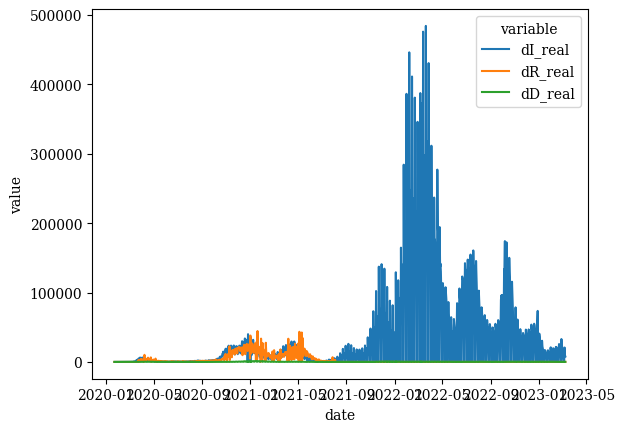

time: 419 ms (started: 2023-07-12 04:27:52 +00:00)


In [ ]:
R = self.real_data.reset_index().rename_axis('t').melt(id_vars='date').dropna()
sns.lineplot(
    data=R,
    x='date',
    y='value',
    hue='variable',
)

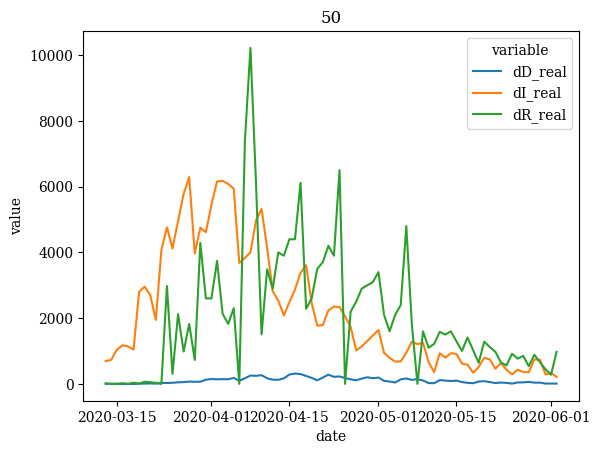

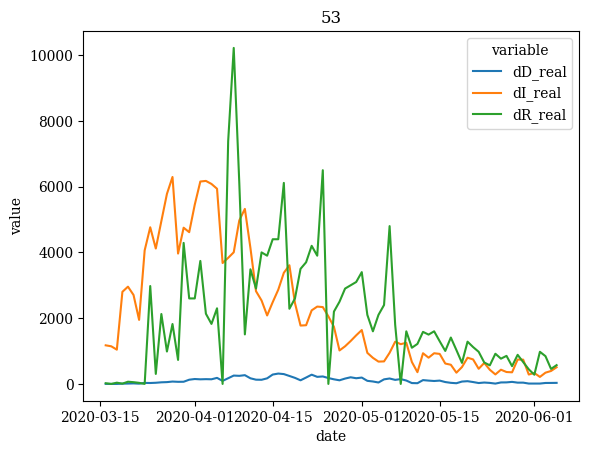

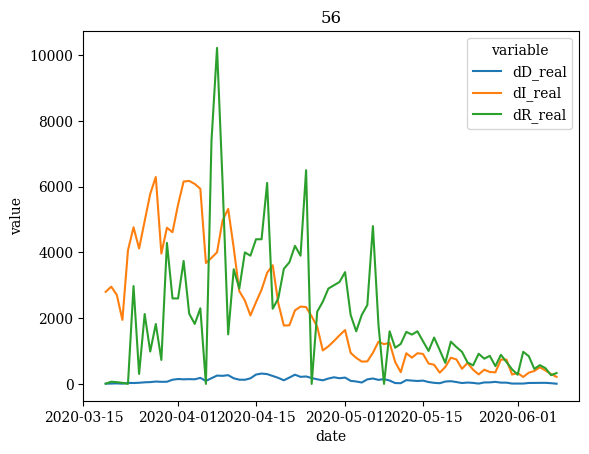

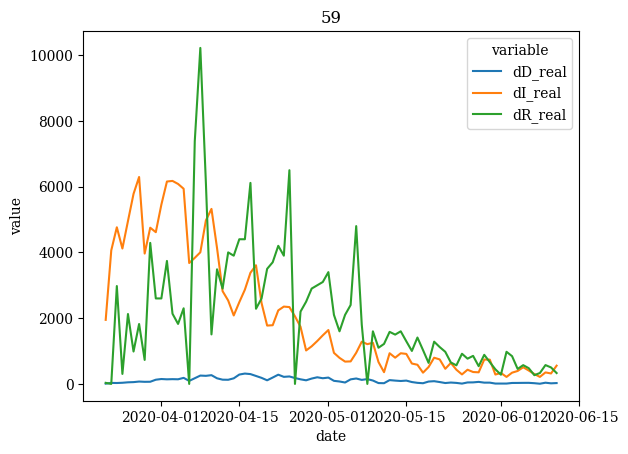

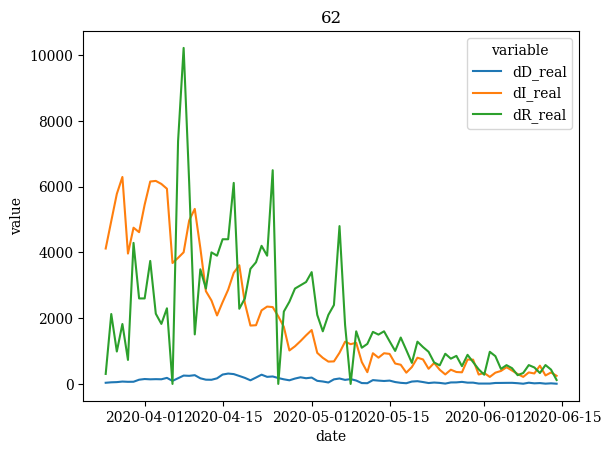

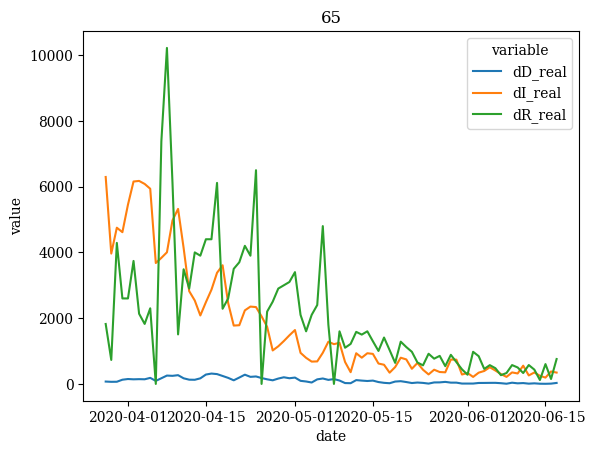

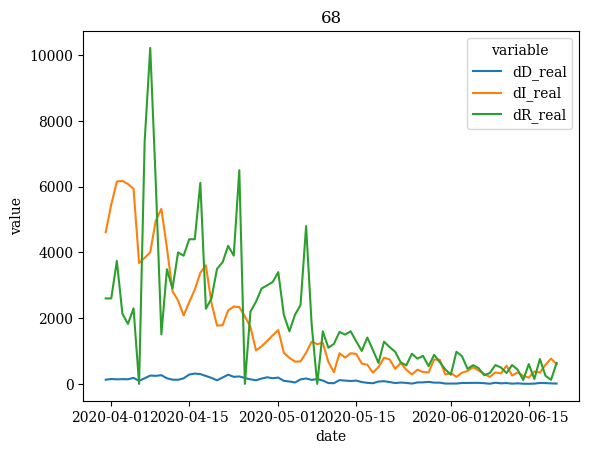

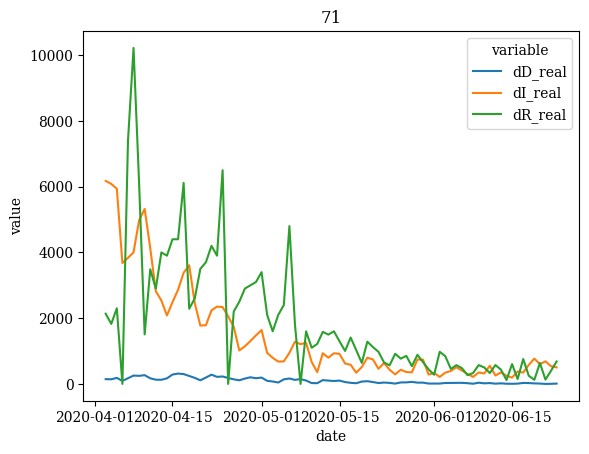

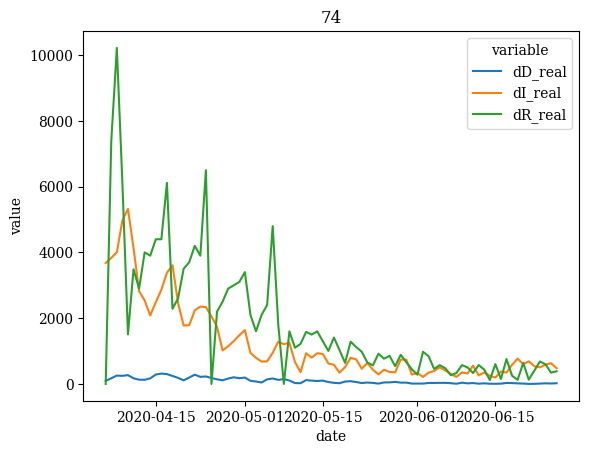

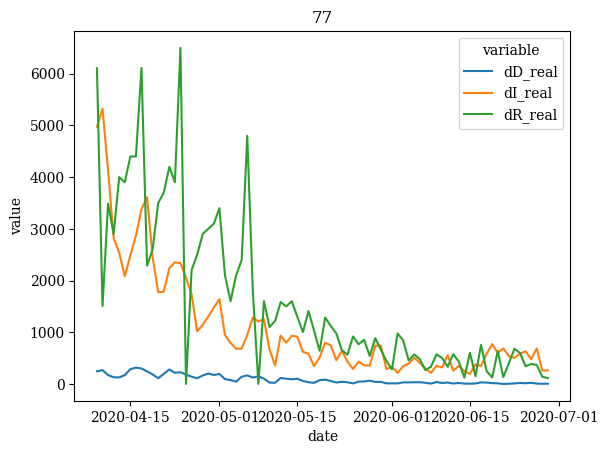

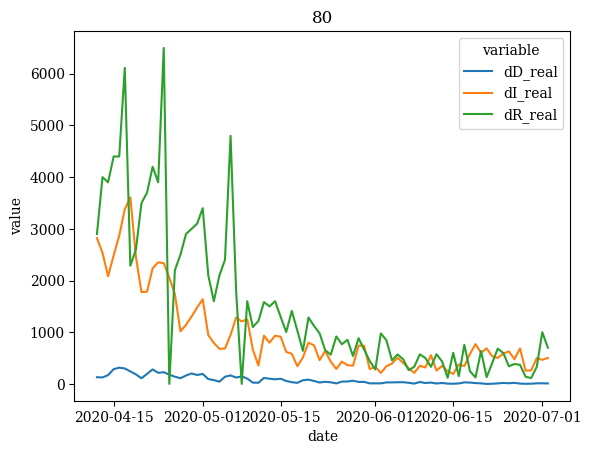

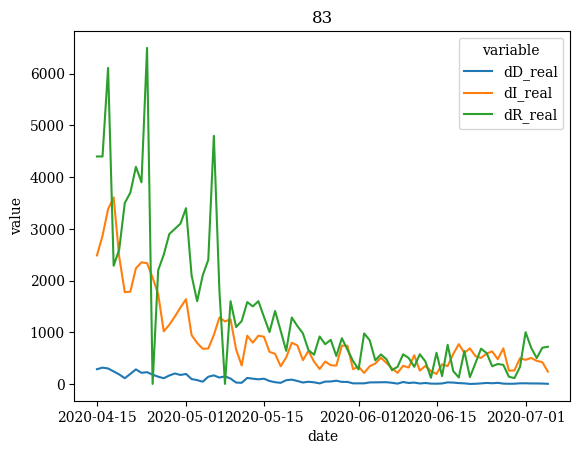

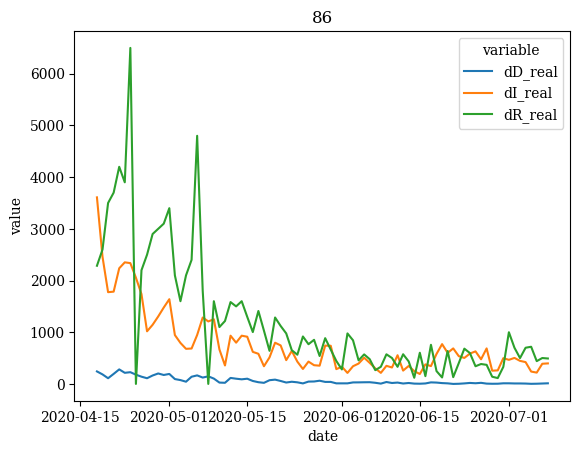

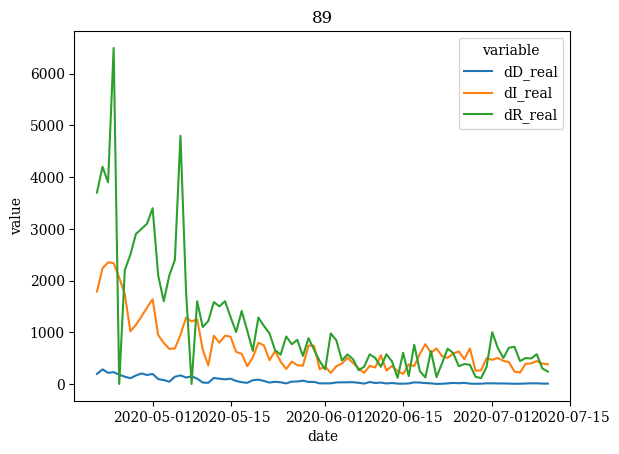

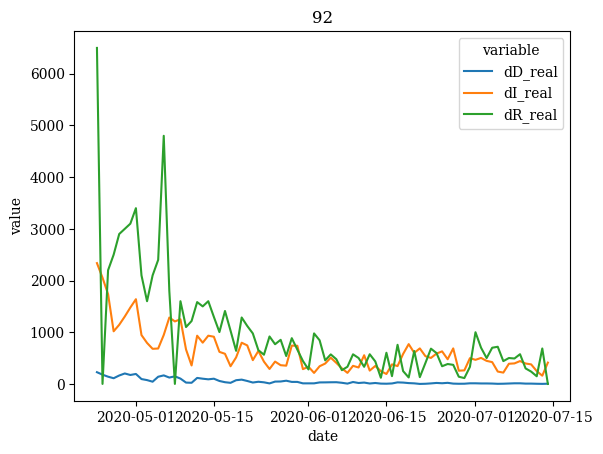

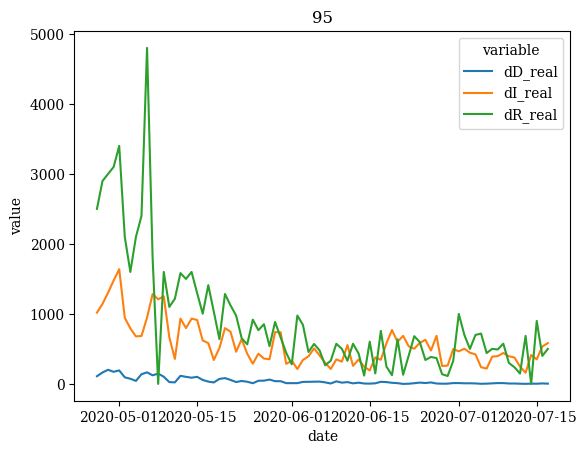

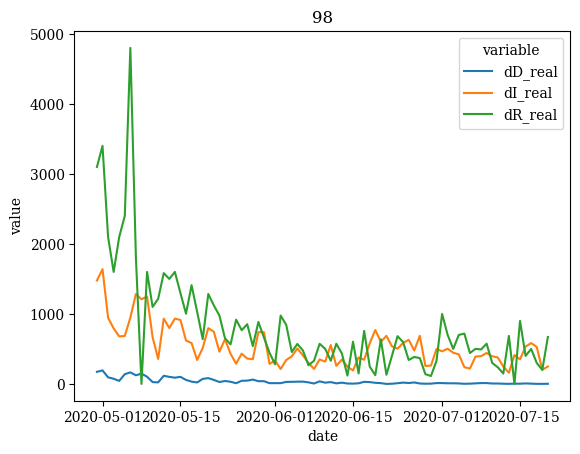

time: 9.86 s (started: 2023-07-12 04:25:38 +00:00)


In [ ]:
for alignment in range(50,100,3):
    self.get_real_data(alignment=alignment)
    # self.plot_predictive(refresh=True)#, n_samples=20)

    R = self.aligned_data.reset_index().rename_axis('t')
    # P = self.predictive['ensemble'].filter(like='obs').join(R['date'])
    Q = R.melt(id_vars='date').dropna()
    # Q = pd.concat([P, R]).melt(id_vars='date').dropna()
    G = Q.groupby(['date','variable']).mean()
    # G.plot()
    sns.lineplot(
        data=G,
        x='date',
        y='value',
        hue='variable',
    )
    plt.title(alignment)
    plt.show()

In [ ]:
pd.DataFrame?

time: 38.4 ms (started: 2023-07-12 02:28:56 +00:00)


In [ ]:
samples['ensemble_draws'][0][0].shape
samples['posterior_draws'][0].shape

# samples['posterior']
# samples['ensemble']

(2, 19)

time: 2.7 ms (started: 2023-07-12 03:00:23 +00:00)


In [ ]:
# self.predictive['ensemble_draws'].shape
# self.predictive['posterior_draws'].shape
# self.predictive['posterior']
self.predictive['ensemble']

AttributeError: ignored

time: 21.1 ms (started: 2023-07-12 02:21:34 +00:00)


In [ ]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
X = self.predictive['posterior_draws'][0]
# cov = MinCovDet()
# cov = EmpiricalCovariance()
mask = np.all((X > self.lower_bound) & (X < self.upper_bound), axis=-1)
# mask = np.all(X > self.lower_bound, axis=-1)
# mask = np.all(X < self.upper_bound, axis=-1)
X = X[mask]
X.shape

# P = self.diagnostic['posterior_draws']
# for p in P:
#     mask = np.all((p > self.lower_bound) & (p < self.upper_bound), axis=-1)
#     q = p[mask]
#     d = 1 / cov.fit(q).mahalanobis(q)
#     d = d / np.sum(d)
#     print(q.shape)
#     RNG.choice(q, size=10, replace=False, p=d)
    # d = (d - d.min()) / (d.max() - d.min())
    # mask = d < 0.7
    # # print(np.sort(d))
    # # print(mask.shape)
    # r = q[mask]
    # print(r.shape)


# mask = np.all(P < self.upper_bound, axis=-1)#, keepdims=True)
# mask.shape, P.shape
# P[mask].shape

(78, 19)

time: 4.46 ms (started: 2023-07-12 01:54:47 +00:00)


In [ ]:
D = self.read_or_create(file=self.file['diagnostic'])
D['posterior_draws'][0].shape

/content/drive/MyDrive/bayesian disease modeling/covid_000/model/diagnostic.pkl successfully read


(100, 19)

time: 186 ms (started: 2023-07-11 23:22:42 +00:00)


In [ ]:
self.param_names

['alpha',
 'beta',
 'gamma',
 'delta',
 'epsilon',
 'eta',
 'lambda',
 'mu',
 'theta',
 'E_0',
 'lag_I',
 'lag_R',
 'lag_D',
 'sigma_I',
 'sigma_R',
 'sigma_D',
 'psi_I',
 'psi_R',
 'psi_D']

time: 8.14 ms (started: 2023-07-12 00:23:38 +00:00)


In [ ]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
X = self.diagnostic['posterior_draws'][0]
cov = MinCovDet()
# cov = EmpiricalCovariance()

D = cov.fit(X).mahalanobis(X)
np.sort(((D - D.min()) / (D.max() - D.min())))
X

array([[0.35684175, 0.2217022 , 0.0997877 , ..., 0.56650644, 0.50558086,
        0.84308001],
       [0.46261109, 0.15748566, 0.14467363, ..., 0.54613465, 0.51119538,
        0.8021059 ],
       [0.61033335, 0.26645812, 0.31668089, ..., 0.45288736, 0.47232558,
        0.415146  ],
       ...,
       [0.29540494, 0.18300541, 0.08276501, ..., 0.52488065, 0.86231452,
        0.28888753],
       [0.18474542, 0.22067032, 0.19737924, ..., 0.37733078, 0.34539843,
        0.49731432],
       [0.36720194, 0.31734468, 0.12729798, ..., 0.51951588, 0.45318659,
        1.00488439]])

time: 130 ms (started: 2023-07-12 00:22:58 +00:00)


In [ ]:

# self.model.amortizer.sample(self.model.generative_model(1), n_samples=1)
x = self.sample(n_sims=1, n_samples=1)
display(pd.DataFrame(x['prior_draws'], columns=self.param_names))
display(x['posterior'].reset_index(drop=True))


,alpha,beta,gamma,delta,epsilon,eta,lambda,mu,theta,E_0,lag_I,lag_R,lag_D,sigma_I,sigma_R,sigma_D,psi_I,psi_R,psi_D
0,0.195138,0.375701,0.091694,0.088277,0.245732,0.2929,0.937657,0.152967,0.329277,34.528976,6.282366,6.688204,8.201152,1.509508,8.733449,4.095045,0.446637,0.791109,0.858368


,alpha,beta,gamma,delta,epsilon,eta,lambda,mu,theta,E_0,lag_I,lag_R,lag_D,sigma_I,sigma_R,sigma_D,psi_I,psi_R,psi_D
0,0.999733,0.177003,0.079936,0.108271,0.247459,0.558782,1.317668,0.110963,0.212641,81.271964,9.428606,7.46794,6.184338,5.213016,10.693721,7.44569,0.508096,0.751352,0.54846


time: 308 ms (started: 2023-07-11 21:44:05 +00:00)


In [ ]:
self.predictive['posterior'].describe()

,alpha,beta,gamma,delta,epsilon,eta,lambda,mu,theta,E_0,lag_I,lag_R,lag_D,sigma_I,sigma_R,sigma_D,psi_I,psi_R,psi_D
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.496344,0.246708,0.121768,0.191027,0.211326,0.437564,0.541249,0.125301,0.241693,81.665210,8.539030,6.794350,8.625013,5.243792,14.085043,2.933514,0.680784,0.337177,0.607066
std,0.237119,0.076867,0.084965,0.079066,0.071072,0.202160,0.259168,0.027758,0.075714,57.935343,1.639497,1.114481,1.605278,3.939614,8.822388,2.680261,0.336141,0.226946,0.269261
min,0.026360,0.086232,0.005300,0.022304,0.067465,0.042680,0.042298,0.059205,0.059276,10.791916,3.934556,2.908454,5.571602,0.089085,0.854466,0.040182,0.054701,0.004202,0.019093
25%,0.318438,0.194644,0.057722,0.132331,0.167326,0.300192,0.359920,0.107954,0.194998,41.408954,7.433210,6.125042,7.442722,2.458492,7.126499,0.999831,0.424642,0.147423,0.439633
50%,0.495057,0.241801,0.099403,0.188764,0.197954,0.413393,0.478803,0.125802,0.246943,61.084120,8.374957,6.918385,8.521190,4.218050,12.144174,2.188975,0.625203,0.331292,0.596243
75%,0.709883,0.290691,0.162497,0.242471,0.260667,0.523425,0.672608,0.141453,0.292282,112.920221,9.625984,7.510355,9.614918,7.167385,20.092939,3.905627,0.867747,0.470486,0.787747
max,0.971259,0.444553,0.417910,0.403789,0.454903,1.303441,1.330861,0.208430,0.459313,350.683036,12.926212,9.412757,13.602089,17.582369,44.400064,14.647006,1.473003,1.006064,1.333346


time: 91.8 ms (started: 2023-07-11 21:53:51 +00:00)


In [ ]:
pd.set_option('display.max_rows', None)
display(self.predictive['ensemble'].query('sim==0 and sample==0').head(100))

,,,S,E,C,I,R,D,dI_obs,dR_obs,dD_obs
t,sim,sample,,,,,,,,,
0,0,0,8.316085e+07,20.163944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,8.316085e+07,19.613616,0.744672,0.098987,0.067989,0.001266,0.000000,0.000000,0.000000
2,0,0,8.316085e+07,19.642675,1.225559,0.332449,0.247846,0.008873,0.000000,0.000000,0.000000
3,0,0,8.316085e+07,20.066165,1.550931,0.635963,0.514149,0.026459,0.000000,0.000000,0.000000
4,0,0,8.316085e+07,20.771924,1.786537,0.972824,0.851386,0.055851,0.000000,0.000000,0.000000
5,0,0,8.316084e+07,21.692436,1.972320,1.322895,1.250248,0.097865,0.000000,0.000000,0.000000
6,0,0,8.316084e+07,22.787679,2.132572,1.675866,1.705360,0.152772,0.000000,0.000000,0.000000
7,0,0,8.316084e+07,24.034678,2.282118,2.027200,2.213892,0.220583,0.000000,0.000000,0.000000
8,0,0,8.316084e+07,25.421137,2.430062,2.375692,2.774704,0.301208,0.000000,0.745466,0.000000


time: 28.7 ms (started: 2023-07-11 21:32:51 +00:00)


In [ ]:
R = self.aligned_data.reset_index().rename_axis('t')
P = (
    self.predictive['ensemble']
    .filter(like='obs')
    .join(R['date'])
    .melt(id_vars='date')
    # .set_index('date')
    # .melt(ignore_index=False)
)
R=R.melt(id_vars='date')
Q = pd.concat([P, R], ignore_index=True)#.reset_index()
Q
# sns.lineplot(
#     data=P,
#     x='date',
#     y='value',
#     hue='variable',
#     # legend=False,
#     # legend='full',
# )


# P
# R.reset_index().rename_axis('t')['date']

# g = P.groupby('t')
# q1 = g.quantile(.25)
# q2 = g.quantile(.50)
# q3 = g.quantile(.75)
# q3.plot()
# R

,date,variable,value
0,2020-02-13,dI_obs,0.0
1,2020-02-14,dI_obs,0.0
2,2020-02-15,dI_obs,0.0
3,2020-02-16,dI_obs,0.0
4,2020-02-17,dI_obs,0.0
...,...,...,...
24841,2020-04-30,dD_real,173.0
24842,2020-05-01,dD_real,193.0
24843,2020-05-02,dD_real,94.0
24844,2020-05-03,dD_real,74.0


time: 29 ms (started: 2023-07-11 19:50:31 +00:00)


In [ ]:
P.reset_index()

,date,variable,value
0,2020-02-13,dI_obs,0.000000
1,2020-02-14,dI_obs,0.000000
2,2020-02-15,dI_obs,0.000000
3,2020-02-16,dI_obs,0.000000
4,2020-02-17,dI_obs,0.000000
...,...,...,...
24595,2020-04-30,dD_obs,2.874989
24596,2020-05-01,dD_obs,4.950418
24597,2020-05-02,dD_obs,5.040551
24598,2020-05-03,dD_obs,0.000000


time: 12.5 ms (started: 2023-07-11 19:43:04 +00:00)


In [ ]:
P['t'] = P.resetndex()['date']index.dt.date()
P

AttributeError: ignored

time: 29.7 ms (started: 2023-07-11 19:45:19 +00:00)


<Axes: xlabel='value', ylabel='date'>

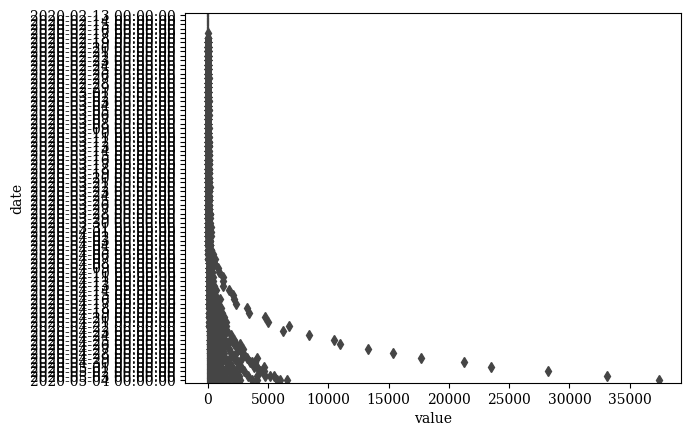

time: 1.65 s (started: 2023-07-11 19:44:21 +00:00)


In [ ]:
sns.boxplot(
    data=P.reset_index(),
    y='date',
    x='value',
    # hue='variable',
    # legend=False,
    # legend='full',
)

In [ ]:
sns.violinplot(
    data=P,
    x='date',
    y='values',
    hue='variable',
)

ValueError: ignored

time: 25.1 ms (started: 2023-07-11 19:41:31 +00:00)


In [ ]:
E = samples['ensemble'].filter(like='obs')
g = E.groupby('t')
q1 = g.quantile(.25)
q2 = g.quantile(.50)
q3 = g.quantile(.75)
(E-q2)/np.fmax(q3-q1,EPS)

In [ ]:
# samples['ensemble'].filter(like='obs').groupby(['sim','sample']).cumsum().round().astype('int')
samples['ensemble'].filter(like='obs').round().groupby('t').mean().astype('int')

In [ ]:
self.real_data.reset_index(drop=True).rename_axis('t')#.cumsum()#.melt(ignore_index=False)

In [ ]:
samples['ensemble'].filter(like='d')

In [ ]:
r = self.get_real_data()
r

In [ ]:
e = samples['ensemble'].filter(like='d').melt(ignore_index=False)
sns.lineplot(
    data=e,
    x='t',
    y='value',
    hue='variable',
    # legend=False,
    # legend='full',
)
r = self.real_data.reset_index(drop=True).rename_axis('t').melt(ignore_index=False)
sns.lineplot(
    data=r,
    x='t',
    y='value',
    hue='variable',
    # legend=False,
    # legend='full',
)

# stack().reset_index()

In [ ]:
r = self.real_data.reset_index(drop=True).rename_axis('t').melt(ignore_index=False)
sns.lineplot(
    data=r,
    x='t',
    y='value',
    hue='variable',
    # legend=False,
    # legend='full',
)


In [ ]:
e = samples['ensemble']
e.groupby(['t',

In [ ]:
e = samples['ensemble']
for nm, ser in e.items():
    ser.reset_index().plot(x='t', y=nm)#, hue='variable')#, legend=False)
    plt.title(nm)
    # display(ser)
    # plt.plot(ser)
    # print(ser)
# plt.plot(

In [ ]:
#  self.model.diagnose_latent2d?
self.model.diagnose_sbc_histograms()

In [ ]:
375+800+2005+650